In [2]:
import os
import json
import time
from timeit import default_timer as timer
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pose_visualisation as vis
import reader, helpers
import torch, torch.nn
import scipy
%matplotlib inline
torch.set_default_dtype(torch.double)

import functools
import scipy.io
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim import Adam
from torch.utils.data import DataLoader
import math
#from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
device ='cpu'
import numpy as np
import torch
from torch.autograd.functional import jacobian, hessian
torch.set_default_dtype(torch.double)
from ipynb.fs.defs.gBAOAB import gBAOAB_integrator, gBAOAB_integrator_mass, gBAOAB_step_exact, rattle_step,gBAOAB_integrator_old
from ipywidgets import IntProgress
from IPython.display import display
import time
import random

In [2]:
def camera_generator(u, consts):
    """Generate camera parameters from (log-)normal model."""
    if u.dim() ==1:
        u = u.unsqueeze(0).detach()
    cam_foc = torch.ones_like(u[:, 0]) * consts['cam_foc']
    cam_pos = torch.concatenate([
        consts['cam_pos_x_mean'] + consts['cam_pos_x_std'] * u[:, 0:1],
        consts['cam_pos_y_mean'] + consts['cam_pos_y_std'] * u[:, 1:2],
        torch.exp(consts['log_cam_pos_z_mean'] +
               consts['log_cam_pos_z_std'] * u[:, 2:3])
    ], 1)
    cam_ang = torch.ones_like(u[:, :3]) * consts['cam_ang']
    return cam_foc, cam_pos, cam_ang

In [3]:
def camera_matrix_batch(focal_length, position, yaw_pitch_roll):
    """Get projective camera matrix given pose and focal length (batch)."""
    if position.ndim == 2:
        n_batch = position.shape[0]
    else:
        n_batch = 1
        focal_length = focal_length.reshape((1,))
        position = position[None, :]
        yaw_pitch_roll = yaw_pitch_roll[None, :]
    cam_mtx = torch.zeros((n_batch, 3, 4))
    rot_mtx = rot_z_batch(yaw_pitch_roll[:, 2])
    rot_mtx = torch.bmm(
        rot_mtx, rot_x_batch(yaw_pitch_roll[:, 1]))
    rot_mtx = torch.bmm(
        rot_mtx, rot_y_batch(yaw_pitch_roll[:, 0]))
    cam_mtx[:, :, :3]= rot_mtx
    cam_mtx[:, :, 3]= position
    int_mtx = torch.stack([focal_length, focal_length,
                        torch.ones_like(focal_length)])
    cam_mtx = (int_mtx * cam_mtx.T).T
    return cam_mtx


In [4]:
def rot_x(ang):
    """Returns matrix which defines rotation by `ang` about x-axis (0-axis)."""
    s = torch.sin(ang)
    c = torch.cos(ang)
    return torch.tensor([
        1, 0, 0,
        0, c, -s,
        0, s, c,
    ]).reshape((3, 3))


def rot_y(ang):
    """Returns matrix which defines rotation by `ang` about y-axis (1-axis)."""
    s = torch.sin(ang)
    c = torch.cos(ang)
    return torch.tensor([
        c, 0, s,
        0, 1, 0,
        -s, 0, c,
    ]).reshape((3, 3))


def rot_z(ang):
    """Returns matrix which defines rotation by `ang` about z-axis (2-axis)."""
    s = torch.sin(ang)
    c = torch.cos(ang)
    return torch.tensor([
        c, -s, 0,
        s, c, 0,
        0, 0, 1,
    ]).reshape((3, 3))


def rot_x_batch(ang):
    """Returns batch of matrices which defines rotations about x-axis (0)."""
    s = torch.sin(ang)
    c = torch.cos(ang)
    rot = torch.eye(3).unsqueeze(0).repeat(ang.shape[0], 1, 1)
    rot[:, 1, 1]=c
    rot[:, 1, 2]= -s
    rot[:, 2, 1]= s
    rot[:, 2, 2]= c
    return rot


def rot_y_batch(ang):
    """Returns batch of matrices which defines rotations about y-axis (1)."""
    s = torch.sin(ang)
    c = torch.cos(ang)
    rot = torch.eye(3).unsqueeze(0).repeat(ang.shape[0], 1, 1)
    rot[:, 0, 0]= c
    rot[:, 0, 2]= s
    rot[:, 2, 0]= -s
    rot[:, 2, 2]= c
    return rot


def rot_z_batch(ang):
    """Returns batch of matrices which defines rotations about z-axis (2)."""
    s = torch.sin(ang)
    c = torch.cos(ang)
    rot = torch.eye(3).unsqueeze(0).repeat(ang.shape[0], 1, 1)
    rot[:, 0, 0]= c
    rot[:, 0, 1]= -s
    rot[:, 1, 0]=s
    rot[:, 1, 1]=c
    return rot


rotation_map = {
    'Xrotation': rot_x,
    'Yrotation': rot_y,
    'Zrotation': rot_z
}
rotation_map_batch = {
    'Xrotation': rot_x_batch,
    'Yrotation': rot_y_batch,
    'Zrotation': rot_z_batch
}

In [5]:
consts = {
    'seed': 1234,
    'n_joint': 19,
    'n_joint_angle': 47,
    'n_joint_angle_latent': 30,
    'n_bone_length_input': 13,
    'n_camera_input': 3,
    'output_noise_std': 0.001,
    'cam_foc': np.exp(2.),
    'cam_pos_x_mean': 0.,
    'cam_pos_y_mean': 0.,
    'cam_pos_x_std': 0.1,
    'cam_pos_y_std': 0.1,
    'log_cam_pos_z_mean': 1.5,
    'log_cam_pos_z_std': 0.5,
    'cam_ang': torch.tensor(np.array([np.pi, 0., 0.])),
    'cam_pos_offset': torch.tensor(np.array([0.5, 0., 0.])),
    'cam_ang_offset': torch.tensor(np.array([0.0, 0., 0.]))
}
consts['n_joint_angle_input'] = (
    consts['n_joint_angle_latent'] +
    consts['n_joint_angle'] * 2)

In [6]:
bvh_reader = reader.BvhReader('skeleton.bvh')
bvh_reader.read()
helpers.process_skeleton(bvh_reader.root)
consts['skeleton'] = bvh_reader.root

with open('fixed_angles.json', 'r') as f:
    consts['fixed_joint_angles'] = json.load(f)

In [7]:
with np.load('params.npz') as f:
    l = 1
    #print(f['W_{0}'.format(l)])
    print('W_{0}'.format(l))

W_1


In [8]:
with np.load('params.npz') as f:
    num_layers = 7
    consts['joint_angles_vae_decoder_layers'] = []
    for l in range(num_layers):
        weight = torch.tensor(f['W_{0}'.format(l)])
        bias = torch.tensor(f['b_{0}'.format(l)])

        linear_layer = torch.nn.Linear(weight.size(0), weight.size(1))
        linear_layer.weight.data = weight
        linear_layer.bias.data = bias
        if l != num_layers - 1:
            nonlinearity = torch.nn.Tanh()
        else:
            nonlinearity = torch.nn.Identity()
        consts['joint_angles_vae_decoder_layers'].append({
            'linear_layer': linear_layer,
            'nonlinearity': nonlinearity })

In [9]:
consts['joints_to_skip'] = [
    'hips',
    'leftshoulder',
    'rightshoulder',
    'lefthandthumb1',
    'righthandthumb1',
    'lefthandthumb1endsite',
    'righthandthumb1endsite',
    'lefttoebaseendsite',
    'righttoebaseendsite'
]
lengths_model_params = np.load('params2.npz')
consts['log_lengths_covar'] = torch.tensor(lengths_model_params['covar'])
consts['log_lengths_covar_chol'] = torch.tensor(la.cholesky(lengths_model_params['covar']))
consts['log_lengths_mean'] = torch.tensor(lengths_model_params['mean'])

In [10]:
with open('lengths_order.json', 'r') as f:
    lengths_order = json.load(f)
    consts['bone_lengths_map'] = {
    node_name: lengths_order[length_name]
    for node_name, length_name
    in helpers.bone_lengths_map.items()
    if node_name not in ['lefthandthumb1endsite', 'righthandthumb1endsite']
}

In [11]:
rng = np.random.RandomState(consts['seed'])

In [12]:
n_noise = consts['n_joint'] * 4
n_in_dim = (
    consts['n_camera_input'] +
    consts['n_bone_length_input'] +
    consts['n_joint_angle_input'] +
    4 * consts['n_joint']
)

In [13]:
# this bit does some weird thing where it pre-calls the function, nothing is actually being generated yet since u is just some constant
# u = tt.matrix('u')
# y_bin = pose.noisy_binocular_2d_proj_generator(u, consts)
# y_3d = pose.joint_3d_pos_generator(u, consts)
# generator_binocular = th.function([u], y_bin)
# generator_3d = th.function([u], y_3d)

In [312]:
def partition(inputs, lengths):
    """Partition a one/two-dimesional tensor in to parts along last axis."""
    i = 0
    parts = []
    for l in lengths:
        parts.append(inputs.T[i:i+l].T)
        i += l
    return parts

In [313]:
def bone_lengths_generator(u, consts):
    """Generate skeleton bone lengths from log-normal model."""
    rng.seed(0)
    u_data = torch.tensor(rng.normal(size=u.size()))
    return torch.exp(consts['log_lengths_mean'] +
                  (u_data @ consts['log_lengths_covar_chol']))

def joint_angles_cos_sin_vae_decoder(h, layers, n_joint_angle):
    h = layers[0]['nonlinearity'](
        (h @ layers[0]['linear_layer'].weight.data) + layers[0]['linear_layer'].bias.data)
    # intermediate layers with skip-connections
    for layer in layers[1:-1]:
        h = layer['nonlinearity'](
            (h@layer['linear_layer'].weight.data) + layer['linear_layer'].bias.data) + h
    h = layers[-1]['nonlinearity'](
    (h@layers[-1]['linear_layer'].weight.data) + layers[-1]['linear_layer'].bias.data)
    print(h.size())
    if h.dim() == 1:
        h =h.unsqueeze(0).detach()
    print(h.size())
    return h[:, :n_joint_angle * 2], torch.exp(0.5 * h[:, n_joint_angle * 2:])


def joint_angles_generator(u, consts):
    """Generate joint angles from VAE decoder model."""
    h, n = partition(u, [consts['n_joint_angle_latent'],
                         consts['n_joint_angle'] * 2])
    ang_cos_sin_mean, ang_cos_sin_std = joint_angles_cos_sin_vae_decoder(
        h, consts['joint_angles_vae_decoder_layers'], consts['n_joint_angle'])
    ang_cos_sin = ang_cos_sin_mean + ang_cos_sin_std * n
    return torch.arctan2(ang_cos_sin[:, consts['n_joint_angle']:],
                      ang_cos_sin[:, :consts['n_joint_angle']])

In [314]:
def joint_positions(node, angles, fixed_angles=None, lengths=None,
                    lengths_map=None, skip=[], i=None, parent_trans=None):
    """Get list of joint pos. given skeleton tree and joint angles."""
    if i is None:
        i = [0]
    if parent_trans is None:
        parent_trans = torch.eye(4)
    joints = []
    rot = torch.eye(3)
    for ch in node.channels:
        ch_key = node.name.lower() + '_' + ch[0].lower()
        if ch in rotation_map:
            if fixed_angles is not None and ch_key in fixed_angles:
                rot = (rot@rotation_map[ch](torch.tensor(fixed_angles[ch_key])))
            else:
                rot = (rot@ rotation_map[ch](torch.tensor(angles[i[0]])))
                i[0] += 1
    local_trans = torch.eye(4)
    local_trans[:3, :3] = rot
    if not (node.name.lower() in skip and node.is_end_site):
        if lengths is None or node.length == 0.:
            node_offset = torch.tensor(np.array(node.offset))
        else:
            length = lengths[lengths_map[node.name.lower()]]
            node_offset = (torch.tensor(node.offset_unit) * length)
        local_trans[:3, 3] = torhc.tensor(node_offset)
        node_trans = parent_trans.dot(local_trans)
        if not node.name.lower() in skip:
            joints.append(node_trans[:, 3])
        for child in node.children:
            joints += joint_positions(child, angles, fixed_angles, lengths,
                                      lengths_map, skip, i, node_trans)
    return joints

In [315]:
def joint_positions_batch(
        node, angles, fixed_angles=None, lengths=None,
        lengths_map=None, skip=[], i=None, parent_trans=None):
    """Get list of joint pos. given skeleton tree and joint angles (batch)."""
    # check whether single vector of angles or mini-batch matrix provided
    if angles.ndim == 2:
        n_batch = angles.shape[0]
    elif angles.ndim == 1:
        n_batch = 1
        angles = angles[None, :]
        if lengths is not None and lengths.ndim == 1:
            lengths = lengths[None, :]
    else:
        raise Exception('angles should be one or two dimensional.')
    if i is None:
        i = [0]
    if parent_trans is None:
        parent_trans = torch.eye(4).unsqueeze(0).repeat(n_batch, 1, 1)
    joints = []
    rot = torch.eye(3).unsqueeze(0).repeat(n_batch, 1, 1)
    for ch in node.channels:
        ch_key = node.name.lower() + '_' + ch[0].lower()
        if ch in rotation_map:
            if fixed_angles is not None and ch_key in fixed_angles:
                rot = rot@(rotation_map[ch](torch.tensor(fixed_angles[ch_key])))
            else:
                rot = torch.bmm(
                    rot, rotation_map_batch[ch](torch.tensor(angles[:, i[0]])))
                i[0] += 1
    local_trans = torch.eye(4).unsqueeze(0).repeat(n_batch, 1, 1)
    local_trans[:, :3, :3] =  rot
    if not (node.name.lower() in skip and node.is_end_site):
        if lengths is None or node.length == 0.:
            node_offset = np.array(node.offset)[None, :]
        else:
            if lengths.dim() == 1:
                lengths = lengths.unsqueeze(0).detach()
            length = lengths[:, lengths_map[node.name.lower()]]
            node_offset = (torch.tensor(node.offset_unit[None, :]) *
                           length[:, None])
        local_trans[:, :3, 3]= torch.tensor(node_offset)
        node_trans = torch.bmm(parent_trans, local_trans)
        if not node.name.lower() in skip:
            joints.append(node_trans[:, :, 3])
        for child in node.children:
            joints += joint_positions_batch(
                child, angles, fixed_angles, lengths,
                lengths_map, skip, i, node_trans)
    return joints


In [316]:
def joint_3d_pos_generator(u, consts):
    """Generate 3D joint positions.

    Generates bone lengths and joint angles from respective models then uses
    skeleton definition to convert to 3D joint positions in global coordinate
    system.
    """
    input_sizes = [consts['n_bone_length_input'],
                   consts['n_joint_angle_input']]
    u_len, u_ang = partition(u, input_sizes)
    bone_lengths = bone_lengths_generator(u_len, consts)
    joint_angles = joint_angles_generator(u_ang, consts)
    print("SHAPE",torch.stack(joint_positions_batch(
        consts['skeleton'], joint_angles, consts['fixed_joint_angles'],
        lengths=bone_lengths, lengths_map=consts['bone_lengths_map'],
        skip=consts['joints_to_skip']), 2).size())
    return torch.stack(joint_positions_batch(
        consts['skeleton'], joint_angles, consts['fixed_joint_angles'],
        lengths=bone_lengths, lengths_map=consts['bone_lengths_map'],
        skip=consts['joints_to_skip']), 2)

In [317]:
def binocular_2d_proj_generator(u, consts):
    """Generate binocular 2D joint position projections.

    Generates bone lengths and joint angles from respective models then uses
    skeleton definition to convert to 3D joint positions in global coordinate
    system, before projecting to two sets of 2D image coordinates using two
    offset generated camera models.
    """
    n_batch = 1
    input_sizes = [consts['n_bone_length_input'] +
                   consts['n_joint_angle_input'],
                   consts['n_camera_input']]
    u_ske, u_cam, = partition(u, input_sizes)
    joint_pos_3d = joint_3d_pos_generator(u_ske, consts)
    cam_foc, cam_pos, cam_ang = camera_generator(u_cam, consts)
    cam_mtx_1 = camera_matrix_batch(
        cam_foc, cam_pos + consts['cam_pos_offset'],
        cam_ang + consts['cam_ang_offset'])
    cam_mtx_2 = camera_matrix_batch(
        cam_foc, cam_pos - consts['cam_pos_offset'],
        cam_ang - consts['cam_ang_offset'])
    joint_pos_2d_hom_1 = torch.bmm(cam_mtx_1, joint_pos_3d)
    joint_pos_2d_1 = (joint_pos_2d_hom_1[:, :2] /
                      joint_pos_2d_hom_1[:, 2][:, None, :])
    joint_pos_2d_hom_2 = torch.bmm(cam_mtx_2, joint_pos_3d)
    joint_pos_2d_2 = (joint_pos_2d_hom_2[:, :2] /
                      joint_pos_2d_hom_2[:, 2][:, None, :])

    print(f"First element: {joint_pos_2d_1.reshape((n_batch, -1)).size()} \n Second Element: {joint_pos_2d_2.reshape((n_batch, -1)).size()}")
    return torch.concatenate(
               [joint_pos_2d_1.reshape((n_batch, -1)),
                joint_pos_2d_2.reshape((n_batch, -1))], 1)



In [318]:
def noisy_binocular_2d_proj_generator(u, consts):
    """Generate noisy binocular 2D joint position projections.

    Generates bone lengths and joint angles from respective models then uses
    skeleton definition to convert to 3D joint positions in global coordinate
    system, before projecting to two sets of 2D image coordinates using two
    offset generated camera models and adding Gaussian observation noise to
    projections.
    """
    input_sizes = [consts['n_bone_length_input'] +
                   consts['n_joint_angle_input'] +
                   consts['n_camera_input'],
                   consts['n_joint'] * 4]
    u_pos, u_noi = partition(u, input_sizes)
    return (binocular_2d_proj_generator(u_pos, consts) +
            consts['output_noise_std'] * u_noi)

## "Observed" Data

In [319]:
n_data = 1
rng.seed(consts['seed'])
u_data = torch.tensor(rng.normal(size=(n_data, n_in_dim)))
y_data = noisy_binocular_2d_proj_generator(u_data, consts)
y_data_3d = joint_3d_pos_generator(u_data, consts)
np.savez('observed-data.npz',u_data=u_data, y_data=y_data, y_data_3d=y_data_3d)

torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
First element: torch.Size([1, 38]) 
 Second Element: torch.Size([1, 38])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])


C:\Users\Tadgh\AppData\Local\Temp\ipykernel_7292\795312297.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rot, rotation_map_batch[ch](torch.tensor(angles[:, i[0]])))
C:\Users\Tadgh\AppData\Local\Temp\ipykernel_7292\795312297.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  local_trans[:, :3, 3]= torch.tensor(node_offset)


In [320]:
y_data_3d[:,0:3,:].squeeze().size()

torch.Size([3, 19])

## Generating a ton of these

In [321]:
transform = torch.zeros((19,3))
for i in range(19):
    transform[i][2] = 2
transform = transform.unsqueeze(0)

In [322]:
train_dataset = []
for i in range(1000):
    n_data = 1
    rng.seed(i)
    u_data = torch.tensor(rng.normal(size=(n_data, n_in_dim)))
    y_data = noisy_binocular_2d_proj_generator(u_data, consts)
    y_data_3d = joint_3d_pos_generator(u_data, consts)
    points_3d = y_data_3d[:,0:3,:].squeeze().T.unsqueeze(0)
    train_dataset.append(points_3d+ transform)

torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
First element: torch.Size([1, 38]) 
 Second Element: torch.Size([1, 38])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
First element: torch.Size([1, 38]) 
 Second Element: torch.Size([1, 38])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
First element: torch.Size([1, 38]) 
 Second Element: torch.Size([1, 38])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])


C:\Users\Tadgh\AppData\Local\Temp\ipykernel_7292\795312297.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rot, rotation_map_batch[ch](torch.tensor(angles[:, i[0]])))
C:\Users\Tadgh\AppData\Local\Temp\ipykernel_7292\795312297.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  local_trans[:, :3, 3]= torch.tensor(node_offset)


First element: torch.Size([1, 38]) 
 Second Element: torch.Size([1, 38])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
First element: torch.Size([1, 38]) 
 Second Element: torch.Size([1, 38])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
First element: torch.Size([1, 38]) 
 Second Element: torch.Size([1, 38])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
First element: torch.Size([1, 38]) 
 Second Element: torch.Size([1, 38])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
First element: torch.Size([1, 38]) 
 Second Element: torch.Size([1, 38])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 1

KeyboardInterrupt: 

In [26]:
train_dataset[0].size()

torch.Size([1, 19, 3])

In [27]:
test_dataset = []
for i in range(1001,1021):
    n_data = 1
    rng.seed(i)
    u_data = torch.tensor(rng.normal(size=(n_data, n_in_dim)))
    y_data = noisy_binocular_2d_proj_generator(u_data, consts)
    y_data_3d = joint_3d_pos_generator(u_data, consts)
    points_3d = y_data_3d[:,0:3,:].squeeze().T.unsqueeze(0)
    test_dataset.append(points_3d+transform)

torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
First element: torch.Size([1, 38]) 
 Second Element: torch.Size([1, 38])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
First element: torch.Size([1, 38]) 
 Second Element: torch.Size([1, 38])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
First element: torch.Size([1, 38]) 
 Second Element: torch.Size([1, 38])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
First element: torch.Size([1, 38]) 
 Second Element: torch.Size([1, 38])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
First element: torch.Size([1, 38]) 
 Second Element: torch.Size([1, 3

C:\Users\Tadgh\AppData\Local\Temp\ipykernel_16692\795312297.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rot, rotation_map_batch[ch](torch.tensor(angles[:, i[0]])))
C:\Users\Tadgh\AppData\Local\Temp\ipykernel_16692\795312297.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  local_trans[:, :3, 3]= torch.tensor(node_offset)


SHAPE torch.Size([1, 4, 19])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
First element: torch.Size([1, 38]) 
 Second Element: torch.Size([1, 38])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
First element: torch.Size([1, 38]) 
 Second Element: torch.Size([1, 38])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
First element: torch.Size([1, 38]) 
 Second Element: torch.Size([1, 38])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
First element: torch.Size([1, 38]) 
 Second Element: torch.Size([1, 38])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
torch.Size([1, 188])
torch.Size([1, 188])
SHAPE torch.Size([1, 4, 19])
First element: torch.Size([1, 38]) 
 Sec

In [28]:
ts = np.array([td[:,:,2].numpy() for td in test_dataset])

In [29]:
ts.min()

1.046350672703582

In [30]:
j3d33 = y_data_3d[:,0:3,:].squeeze().T

(<Figure size 800x800 with 1 Axes>, <Axes3D: >)

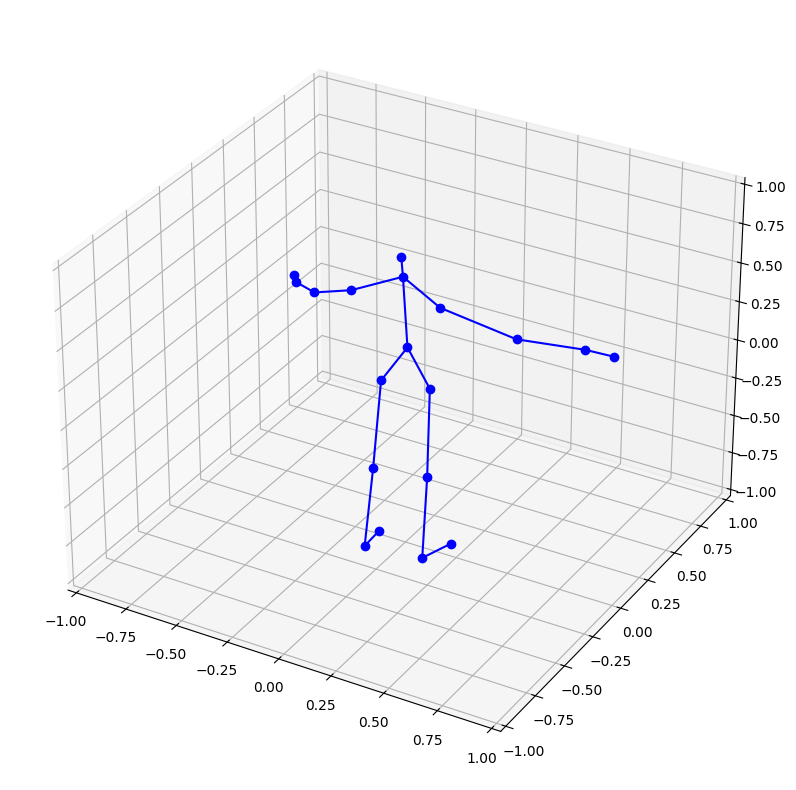

In [31]:
vis.plot_3d_pose(j3d33)

## PCA

In [32]:
train_data = np.array([d.numpy() for d in train_dataset])
test_data = np.array([d.numpy() for d in test_dataset])

In [33]:
list = np.transpose(np.array([data[0].flatten().numpy() for data in train_dataset]))

In [34]:
np.shape(list)

(57, 1000)

In [35]:
U, S,_=np.linalg.svd(list)

In [36]:
eigenposes = np.transpose(U)
eigenvalues = S**2

In [37]:
eigenvalues = eigenvalues[:-2]
eigenposes = eigenposes[:-2]

In [38]:
eigenvalues

array([8.54360062e+04, 7.27653886e+02, 6.01580515e+02, 4.48676621e+02,
       3.87832366e+02, 3.41813750e+02, 2.89949931e+02, 1.86479657e+02,
       1.48836821e+02, 1.36835666e+02, 1.05429515e+02, 1.03264144e+02,
       7.05219759e+01, 3.63260194e+01, 3.17894387e+01, 1.67378118e+01,
       1.57641929e+01, 1.25499368e+01, 1.22249128e+01, 9.66764985e+00,
       8.07235584e+00, 7.22038285e+00, 6.05057712e+00, 5.10947847e+00,
       4.44294399e+00, 3.90344966e+00, 2.48950539e+00, 2.35950842e+00,
       1.71521265e+00, 1.62473641e+00, 1.50151561e+00, 1.42228935e+00,
       1.37708453e+00, 1.16236956e+00, 1.09717639e+00, 9.41464958e-01,
       8.77420066e-01, 8.61755639e-01, 7.28959294e-01, 6.64709649e-01,
       5.37449986e-01, 4.52088066e-01, 4.06453418e-01, 3.50176987e-01,
       3.18926991e-01, 2.62510916e-01, 2.57281478e-01, 2.19948937e-01,
       2.08249316e-01, 1.92022092e-01, 1.84130130e-01, 1.65690117e-01,
       1.48720973e-01, 1.39112557e-01, 1.20910088e-01])

In [39]:
# getting rid of insignificant eigenvalues

In [40]:
eigenposes[0]

array([-2.12761502e-04, -2.01528574e-02, -2.19229755e-01, -8.54189830e-04,
       -6.69889822e-02, -2.22705683e-01, -4.61122666e-04, -7.91659736e-02,
       -2.23958850e-01, -1.56573132e-02, -5.80320402e-02, -2.20174127e-01,
       -2.88109305e-02, -3.54257798e-02, -2.22024405e-01, -3.22794920e-02,
       -2.66520600e-02, -2.33275062e-01, -3.42909520e-02, -2.30940129e-02,
       -2.36836844e-01,  1.28013097e-02, -6.05153377e-02, -2.18204290e-01,
        2.46384416e-02, -4.49261108e-02, -2.16401780e-01,  2.89178730e-02,
       -3.84949398e-02, -2.24085702e-01,  3.04861536e-02, -3.58561005e-02,
       -2.26973229e-01, -8.04677626e-03,  4.17550003e-04, -2.16806198e-01,
       -9.18851735e-03,  4.95023749e-02, -2.17249759e-01, -9.83995587e-03,
        9.30985586e-02, -2.12217005e-01, -1.26825857e-02,  9.72243099e-02,
       -2.25855518e-01,  8.04677626e-03, -4.17550003e-04, -2.15411567e-01,
        1.21178461e-02,  4.13775469e-02, -2.19389018e-01,  1.03436973e-02,
        8.04373629e-02, -

In [41]:
# getting the average pose
avg_pose = np.squeeze(train_data.mean(axis=0))
avg_pose = np.ndarray.flatten(avg_pose)
avg_pose.reshape(19, 3)

array([[ 1.54378786e-03,  1.85443452e-01,  2.02783681e+00],
       [ 7.15177198e-03,  6.16135369e-01,  2.05643717e+00],
       [ 3.66312192e-03,  7.27969933e-01,  2.06695776e+00],
       [ 1.41141340e-01,  5.33287054e-01,  2.03390180e+00],
       [ 2.59752247e-01,  3.24557551e-01,  2.04996494e+00],
       [ 2.90920399e-01,  2.42109637e-01,  2.15090984e+00],
       [ 3.08873198e-01,  2.08597296e-01,  2.18271858e+00],
       [-1.15767877e-01,  5.56502405e-01,  2.01582827e+00],
       [-2.22088336e-01,  4.13850799e-01,  1.99776002e+00],
       [-2.60815992e-01,  3.54680433e-01,  2.06546772e+00],
       [-2.74884652e-01,  3.30358341e-01,  2.09085564e+00],
       [ 7.27287893e-02, -3.76828728e-03,  2.00641372e+00],
       [ 8.24433404e-02, -4.55601509e-01,  2.00894777e+00],
       [ 8.81791773e-02, -8.56597935e-01,  1.96308026e+00],
       [ 1.12934569e-01, -8.94835659e-01,  2.08626074e+00],
       [-7.27287893e-02,  3.76828728e-03,  1.99358628e+00],
       [-1.08154505e-01, -3.82445972e-01

In [42]:
def length_constraint(i,j, init):
    def constraint_fn(x):
        return (x[3*i]- x[3*j])**2 +(x[3*i+1]- x[3*j+1])**2 + (x[3*i+2]- x[3*j+2])**2 - ((init[3*i]- init[3*j])**2 +(init[3*i+1]- init[3*j+1])**2 + (init[3*i+2]- init[3*j+2])**2)
    return constraint_fn

In [43]:
i = 0
j=1

In [44]:
x_init = train_dataset[0]
lengths = []
for n in range(50):
    x = torch.flatten(train_dataset[n][0])
    l = (x[3*i]- x[3*j])**2 +(x[3*i+1]- x[3*j+1])**2 + (x[3*i+2]- x[3*j+2])**2
    lengths.append(l)

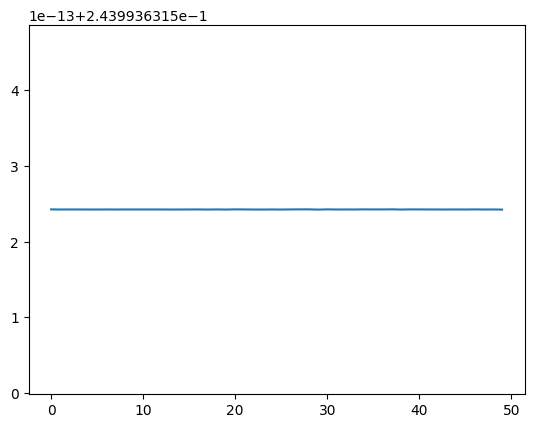

In [45]:
plt.plot(lengths)

In [46]:
def avg_j2j(frame1,frame2):
    dists = []
    frame_1 = np.array(frame1)
    frame_2 = np.array(frame2)
    for i in range(len(frame1)):
        d = math.dist(frame_1[i], frame_2[i])
        dists.append(d)
    return np.mean(dists)

In [47]:
h = .0001

In [48]:
# taking the list of bones from pose_visualisation for the constraints
bones = [
    (0, 1),
    (1, 2),
    (1, 3),
    (3, 4),
    (4, 5),
    (5, 6),
    (1, 7),
    (7, 8),
    (8, 9),
    (9, 10),
    (0, 11),
    (11, 12),
    (12, 13),
    (13, 14),
    (0, 15),
    (15, 16),
    (16, 17),
    (17, 18),
]

In [49]:
diffs = []

f = IntProgress(min=0, max=len(test_dataset[0:100]))
display(f)
for frame1 in test_dataset[1:2]:

    frame = torch.squeeze(frame1)

    M = torch.eye(19*3)


    # initialising from a random training pose
    x_init = torch.flatten(train_dataset[random.randint(0,99)])
    v_init = torch.zeros_like(x_init)
    x_init.requires_grad =True

    gs = [length_constraint(i,j,x_init) for (i,j) in bones]


    # defining and randomly perturbing the image
    fx = 1.0
    fy = 1.0
    cx = 0
    cy = 0
    a1 = torch.tensor([[fx], [0], [cx]], dtype=torch.double)
    a2 = torch.tensor([[0], [fy], [cy]], dtype=torch.double)
    a3 = torch.tensor([[0],[0],[1]], dtype=torch.double)
    i1 = frame @ a1
    i2 = frame @ a2
    i3 = frame @ a3

    image = torch.hstack([i1/i3, i2/i3])


    image += torch.randn_like(image) * 0.01

    # need to re-define density, force and mass to use the new image
    def neg_log_density(pose2):
        pose = pose2.reshape((19,3))
        pose = torch.squeeze(pose)
        fx = 1.0
        fy = 1.0
        cx = 0
        cy = 0
        a1 = torch.tensor([[fx], [0], [cx]], dtype=torch.double)
        a2 = torch.tensor([[0], [fy], [cy]], dtype=torch.double)
        a3 = torch.tensor([[0],[0],[1]], dtype=torch.double)

        # Map the 3D point to 2D point
        p1 = pose@ a1
        p2 = pose @ a2
        p3 = pose @ a3

        projection = torch.hstack([p1/p3, p2/p3])
        #print(projection)
        #print(image)
        n = projection - image
        #print(n)
        # note - taking the variance to be 1...
        pi = torch.tensor([0.], requires_grad=True)
        for point in n:
            pi = pi+ (torch.dot(point,point)) / .01**2

        p2 = torch.flatten(pose)
        for i in range(len(eigenvalues)):
            pi = pi+ (torch.dot(torch.tensor(eigenposes[i]),(p2-torch.tensor(avg_pose)))**2 / eigenvalues[i])
        return pi

    def force(x):
        return torch.squeeze(jacobian(neg_log_density, x), dim = 0)

    def rmse_fn(x):
        r = avg_j2j(x.reshape((19,3)),frame)
        return r
    positions, velocities = gBAOAB_integrator(x_init,v_init, force,gs, h,M, 1, 1, 500, rmse_fn)

    # getting the mean position
    mean = torch.tensor(np.array(torch.stack(positions[0:]).detach()).mean(axis=0))

    # getting mean difference between this and the pose
    jd = avg_j2j(mean.reshape((19,3)),frame)
    print("GBAOAB - joint to joint:", jd)
    diffs.append(jd)

    print(f"GBAOAB - RMSE: {((mean - torch.flatten(frame))**2).mean()**0.5}")
    errors = []
    for i in range(len(positions)):
        mean_to_i = np.array(torch.stack(positions[:i+1]).detach().mean(axis=0))
        rmse1 = ((mean_to_i - torch.flatten(frame).numpy())**2).mean()**0.5
        errors.append(rmse1)

    errors_2 = []
    for i in range(len(positions)):
        mean2= positions[i].detach().numpy()
        rmse2 = ((mean2 - torch.flatten(frame).detach().numpy())**2).mean()**0.5
        errors_2.append(rmse2)

    densities =[]
    for position in positions:
        densities.append(neg_log_density(position).detach())

    plt.plot(np.array(errors), label ='Average joint-to-joint error')
    plt.plot(np.array(errors_2), label ='Average joint-to-joint error per iteration')
    plt.xlabel('Iteration')
    plt.title('RMSE per iterati\on')
    plt.legend()
    plt.savefig('my_results_31.pdf')

    # BFGS
    print(f"Average joint movement: {avg_j2j(mean.reshape((19,3)),x_init.detach().reshape((19,3)))}")

IntProgress(value=0, max=20)

TypeError: gBAOAB_integrator() missing 1 required positional argument: 'error'

In [ ]:
for i in [0,4,14,19]:
    vis.plot_3d_pose(positions[i].detach().reshape((19,3))- transform)
    plt.title(f"pose {i}")
    plt.savefig(f"pose_{i}.pdf")

In [80]:
reverse_pose = np.load('reverse_pos_new.npy',allow_pickle=True)

midpos = reverse_pose[500].reshape((19,3))                                  
inpos = reverse_pose[0].reshape((19,3))

In [81]:
transform = torch.ones_like(inpos) / 2

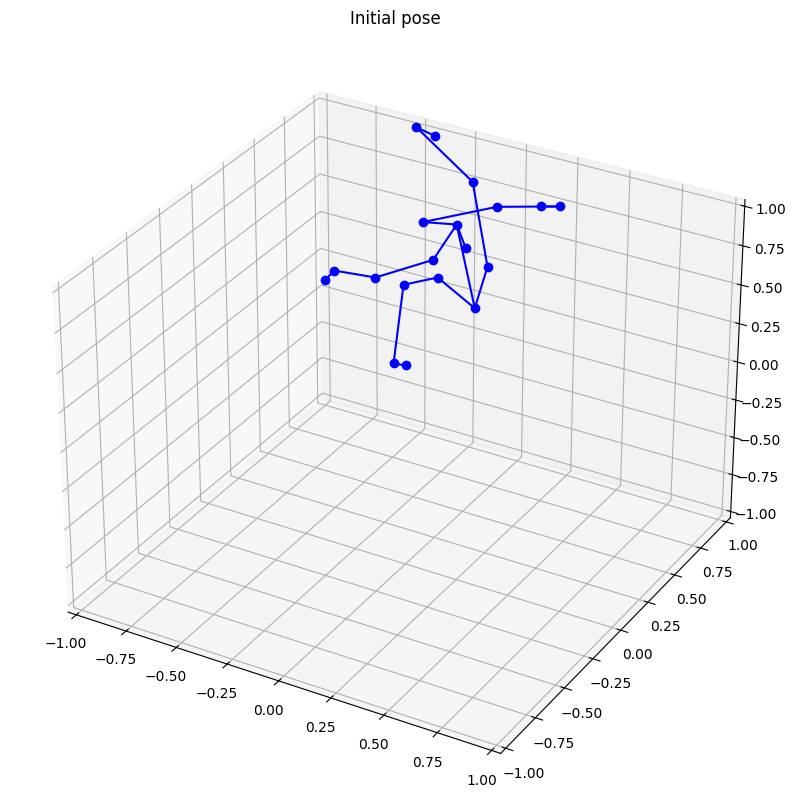

In [82]:
fig, ax = vis.plot_3d_pose(inpos- transform)
plt.title(f"Initial pose")
plt.savefig(f"fp.pdf")

In [83]:
midpos[0]=torch.zeros_like(inpos[0])
midpos[0][-1] =2

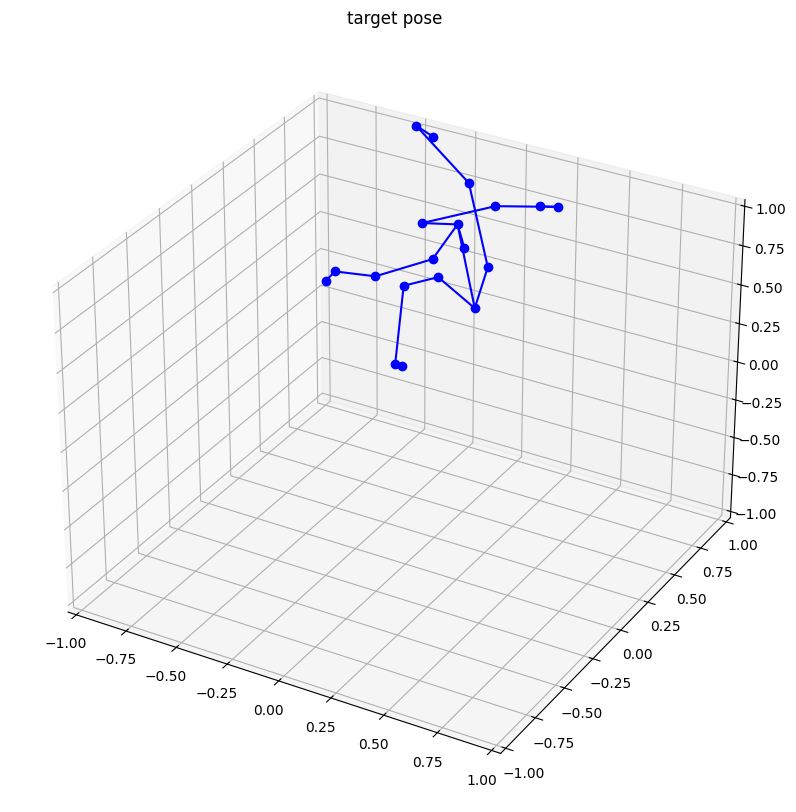

In [84]:
fig, ax = vis.plot_3d_pose(midpos- transform)
plt.title(f"target pose")
plt.savefig(f"fp.pdf")

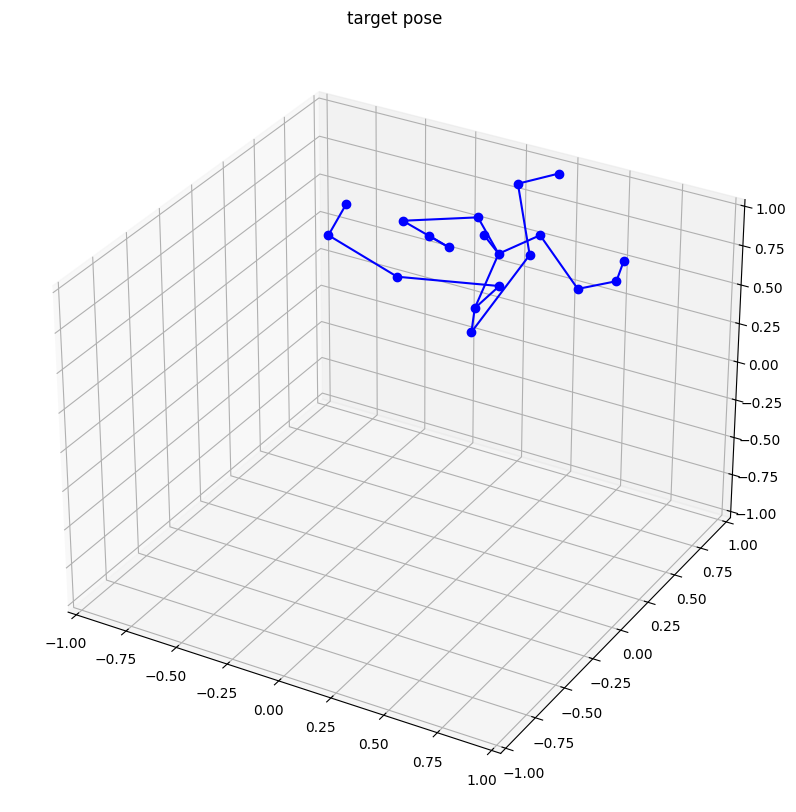

In [87]:
finpos = reverse_pose[-1].reshape((19,3))

finpos[0]=torch.zeros_like(finpos[0])
finpos[0][-1] =2

fig, ax = vis.plot_3d_pose(finpos- transform)
plt.title(f"target pose")
plt.savefig(f"fp.pdf")

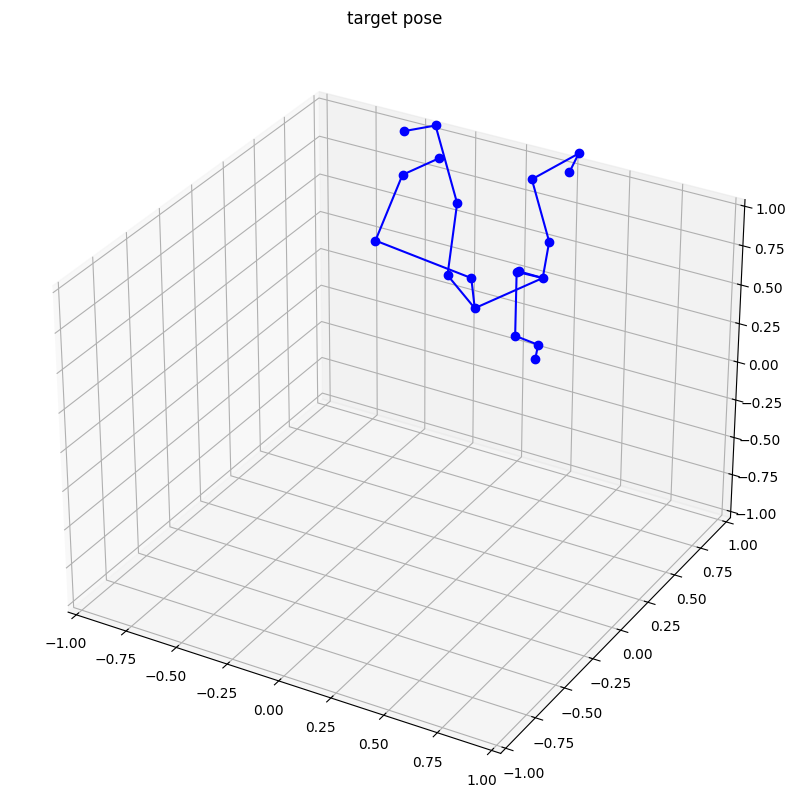

In [128]:
final_pose =positions[-1].detach().reshape((19,3))

NameError: name 'positions' is not defined

In [ ]:
mean = torch.stack(positions).detach().mean(axis=0).reshape((19,3))

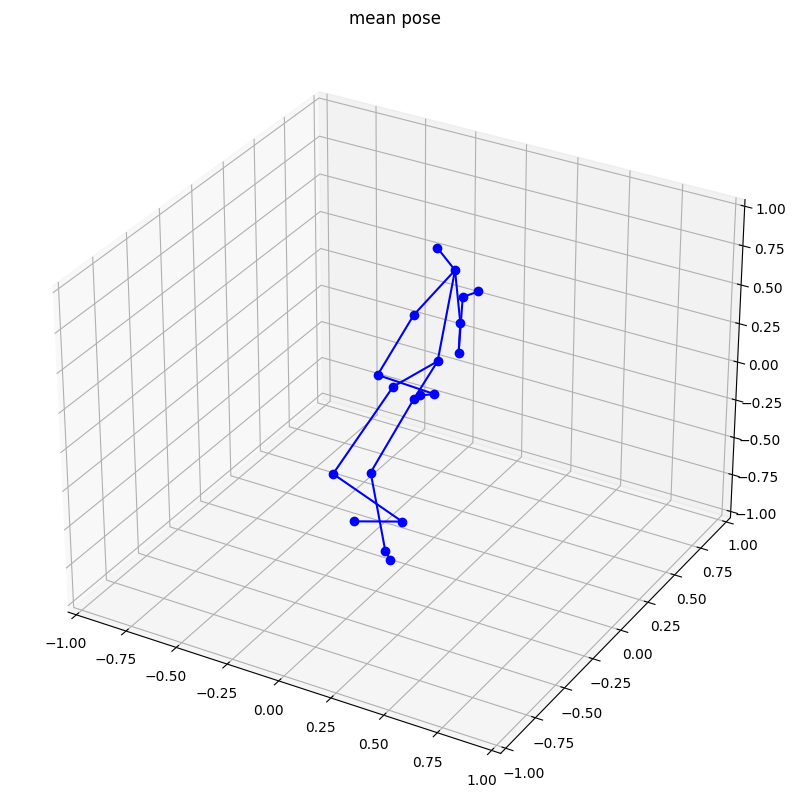

In [57]:
vis.plot_3d_pose(final_pose- transform)
plt.title(f"mean pose")
plt.savefig(f"pose_mean.pdf")

In [ ]:
image

In [ ]:
plt.scatter(image[:,0], image[:,1])

In [ ]:
fx = 1.0
fy = 1.0
cx = 0
cy = 0
a1 = torch.tensor([[fx], [0], [cx]], dtype=torch.double)
a2 = torch.tensor([[0], [fy], [cy]], dtype=torch.double)
a3 = torch.tensor([[0],[0],[1]], dtype=torch.double)

# Map the 3D point to 2D point
p1 = mean@ a1
p2 = mean @ a2
p3 = mean @ a3

projection = torch.hstack([p1/p3, p2/p3])

In [ ]:
plt.scatter(projection[:,0],projection[:,1])

In [ ]:
densities = [d.detach() for d in densities]

In [ ]:
plt.plot(densities)

In [ ]:
print(eigenvalues)

In [ ]:
x_init= test_dataset[0]
t = torch.ones_like(x_init)*0.01

In [ ]:
print(neg_log_density(x_init))

In [ ]:
print(neg_log_density(x_init+t))

In [ ]:
errors = []
for i in range(len(positions)):
    mean_to_i = positions[:i]
    rmse = ((mean - torch.flatten(frame))**2).mean()**0.5
    errors.append(rmse)

In [ ]:
i=0
j=1

In [ ]:
for n in range(len(positions)):
    x = positions[n]
    l = (x[3 * i] - x[3 * j]) ** 2 + (x[3 * i + 1] - x[3 * j + 1]) ** 2 + (x[3 * i + 2] - x[3 * j + 2]) ** 2
    lengths.append(l)
plt.plot(lengths)

In [ ]:
def force(x):
    return torch.zeros_like(x)

In [ ]:
bones2 = [
    (0, 1),
    (1, 3),
    (3, 4),
    (4, 5),
    (5, 6),
    (1, 7),
    (7, 8),
    (8, 9),
    (9, 10),
    (0, 11),
    (11, 12),
    (12, 13),
    (13, 14),
    (0, 15),
    (15, 16),
    (16, 17),
    (17, 18),
]

In [ ]:
def noising_process(pose,p, its, h):
    gs = [length_constraint(i,j,x_init) for (i,j) in bones]
    M = torch.eye(len(pose))
    qs, ps = gBAOAB_integrator_old(pose,p,force, gs, h,M, 1, 1, its)
    return qs[-1], ps[-1]

In [ ]:
q0 = torch.flatten(test_dataset[0])
q1, v1 = noising_process(q0,torch.zeros_like(q0), 1,0.01)

In [ ]:
q2,v2 = noising_process(q1,v1,9,0.01)
q3,v3 = noising_process(q2,v2,10,0.01)

In [ ]:
pose0 = q0.reshape((19,3))
pose1 = q1.detach().reshape((19,3))
pose2 = q2.detach().reshape((19,3))
pose3 = q3.detach().reshape((19,3))

In [ ]:
t2 = torch.zeros_like(pose0)
t2[2] = 1

In [ ]:
q0 = torch.flatten(test_dataset[0])
pose0 = q0.reshape((19,3))

In [ ]:
transform = torch.ones_like(pose0)/2
fig, ax = vis.plot_3d_pose(pose0- transform)
ax.plot((pose0-transform)[2][0],(pose0-transform)[2][2],(pose0-transform)[2][1],'o', color = 'red')
ax.set_title('t=0')
plt.savefig('t_0.pdf')

In [ ]:
pose0[2]

In [ ]:
(pose1-transform)[2][1]

In [ ]:
fig, ax =vis.plot_3d_pose(pose1- transform)
#ax.plot(x,(pose1-transform)[2][2],(pose1-transform)[2][1],'o', color = 'red')
ax.set_title('t=0.01')
plt.savefig('t_001.pdf')

In [ ]:
fig, ax =vis.plot_3d_pose(pose2- transform)
ax.plot((pose2-transform)[2][0],(pose2-transform)[2][2],(pose2-transform)[2][1],'o', color = 'red')
ax.set_title('t=0.1')
plt.savefig('t_01.pdf')

In [ ]:
fig, ax =vis.plot_3d_pose(pose3- transform)
ax.plot((pose3-transform)[2][0],(pose3-transform)[2][2],(pose3-transform)[2][1],'o', color = 'red')
ax.set_title('t=0.2')
plt.savefig('t_02.pdf')

In [ ]:
vis.plot_3d_pose(pose3- transform)
plt.title("t = .14")
plt.savefig('t_14.pdf')

## Geodesic Random Walk

In [221]:
np_poses = np.load('numpy data\\0-100.npy',allow_pickle=True)

In [225]:
np_poses[0]

array([tensor([ 9.2871e-04, -6.4049e-04,  1.9999e+00, -4.1988e-02,  4.9122e-01,
                1.9694e+00, -2.9646e-02,  6.2745e-01,  1.9811e+00,  7.7197e-02,
                3.8383e-01,  1.7852e+00,  1.8743e-01,  4.9913e-02,  1.7400e+00,
                3.0568e-01, -2.1782e-01,  1.7436e+00,  3.2959e-01, -3.4052e-01,
                1.7470e+00, -1.8147e-01,  4.8868e-01,  2.0444e+00, -1.7960e-01,
                6.3993e-01,  2.3650e+00, -1.8817e-01,  8.6846e-01,  2.1823e+00,
               -2.1130e-01,  9.3984e-01,  2.0823e+00,  1.1015e-01, -2.0309e-01,
                1.9270e+00,  1.5329e-01, -7.2401e-01,  1.8924e+00,  1.8932e-01,
               -1.1902e+00,  1.8480e+00,  2.5344e-01, -1.2210e+00,  2.0352e+00,
               -8.1728e-02, -2.2643e-01,  2.0275e+00, -8.9744e-02, -7.4065e-01,
                1.9278e+00, -9.1450e-02, -1.2057e+00,  1.8626e+00, -1.5708e-01,
               -1.2487e+00,  2.0468e+00])                                      ,
       tensor([ 2.7625e-03, -1.9934e-03

In [269]:
init = torch.flatten(np_poses[10][0]).reshape((19,3))
mid = torch.flatten(np_poses[10][20]).reshape((19,3))
fin = torch.flatten(np_poses[10][99]).reshape((19,3))

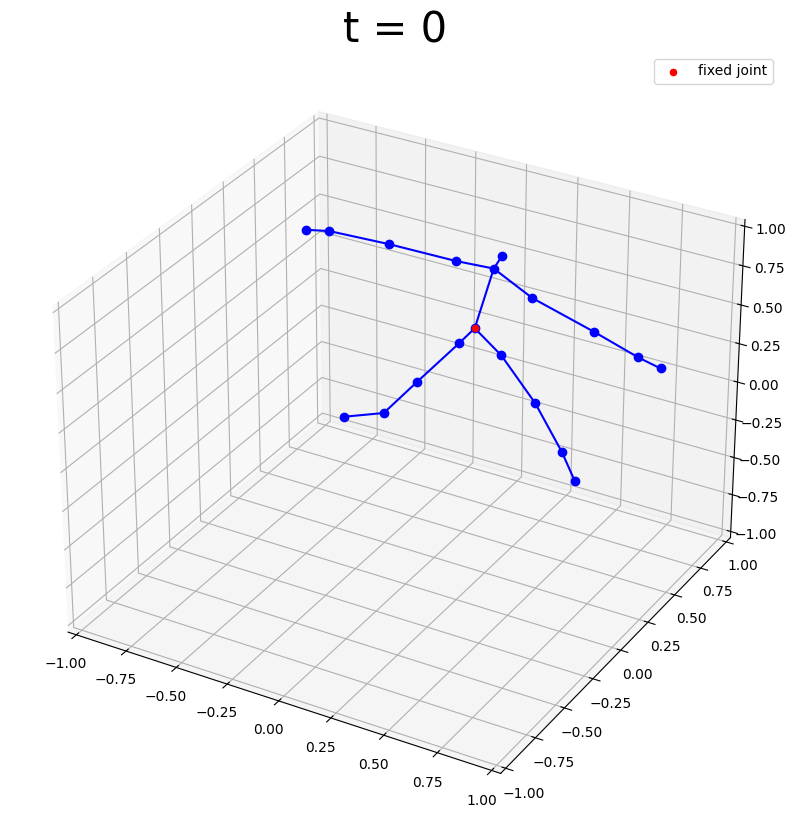

In [282]:
init[0] = torch.zeros_like(init[0])
init[0][-1] = 2
fig, ax = vis.plot_3d_pose(init - transform)
ax.scatter((init - transform)[0][0],(init - transform)[0][2],(init - transform)[0][1], color = 'red', label = 'fixed joint')
plt.title(f"t = 0", fontsize = 30)
plt.legend()
plt.savefig(f"t_0.pdf", bbox_inches = 'tight')

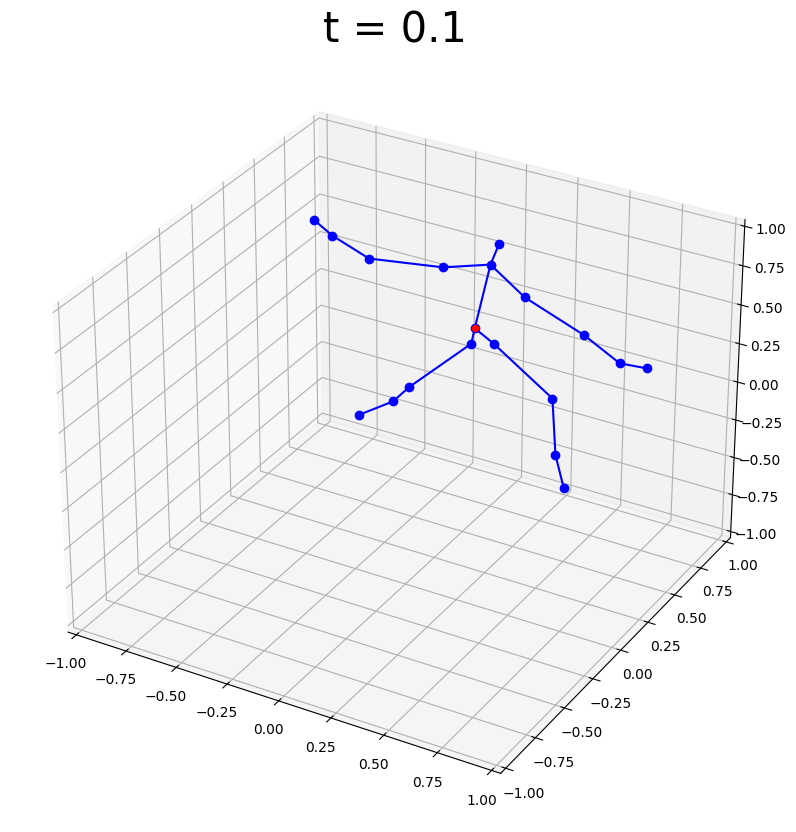

In [283]:
mid[0] = torch.zeros_like(mid[0])
mid[0][-1] = 2
fig, ax = vis.plot_3d_pose(mid - transform)
ax.scatter((mid - transform)[0][0],(mid- transform)[0][2],(mid - transform)[0][1], color = 'red', label = 'fixed joint')
plt.legend()
plt.title(f"t = 0.1", fontsize = 30)
plt.savefig(f"t_01.pdf", bbox_inches = 'tight')

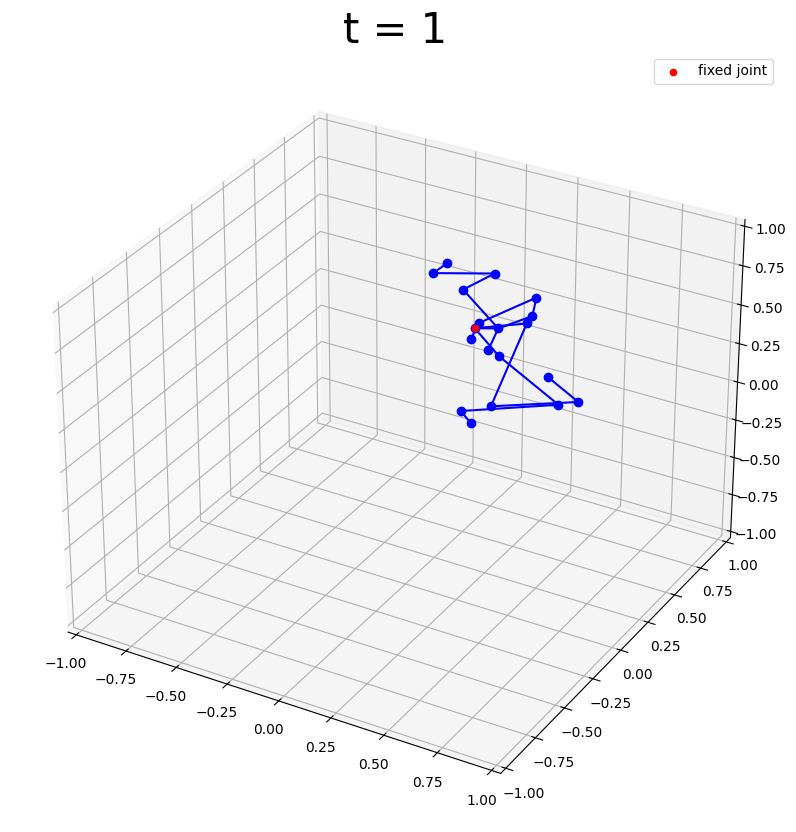

In [284]:
fin[0] = torch.zeros_like(fin[0])
fin[0][-1] = 2
fig, ax = vis.plot_3d_pose(fin - transform)
plt.title(f"t = 1", fontsize = 30)
ax.scatter((fin - transform)[0][0],(fin- transform)[0][2],(fin - transform)[0][1], color = 'red', label = 'fixed joint')
plt.legend()
plt.savefig(f"t_100.pdf", bbox_inches = 'tight')